In [1]:
# Clear all existing variables
%reset -f

In [2]:
#packages
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Widening the screen
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# Widening the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
FS=25
rcParams['figure.dpi'] = 1800
rcParams['savefig.dpi'] = 800
rcParams['font.size'] = FS
rcParams['font.family'] = 'StixGeneral'
rcParams["mathtext.fontset"] = 'stix'
# rcParams["mathtext.default"] = "rm" 
# rcParams['xtick.direction'] = 'in'
plt.rc('font', size=FS)          # controls default text sizes
plt.rc('axes', titlesize=FS)     # fontsize of the axes title
plt.rc('axes', labelsize=FS)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=FS)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FS)    # fontsize of the tick labels
plt.rc('legend', fontsize=FS)    # legend fontsize
plt.rc('figure', titlesize=FS)   # fontsize of the figure title

In [4]:
#grid
LX =435
LT =100
dx =1.0
dt =0.001

In [5]:
#parameter
#Ph: N1
D1  =162.0
A11 =1.0
A21 =0.917
A31 =0.962

#Su: N2
D2  =10.0
A12 =1.0
A22 =1.0
A32 =1.0

#Sp: N3
D3  =78.5
A13 =1.0
A23 =0.984
A33 =1.0

R1  =np.zeros(LX)+1.0
R2  =np.zeros(LX)+1.0
R3  =np.zeros(LX)+1.0
R1[30:180] =R1[30:180]-np.linspace(1,0,150)
R2[30:180] =R2[30:180]-np.linspace(1,0,150)
R3[30:60]  =R3[30:60] -np.linspace(1,0,30)
R1[0:30] =0.0
R2[0:30] =0.0
R3[0:30] =0.0

In [6]:
#import data
import pandas
# area
df       = pandas.read_csv('./Data S1 Percent cover.csv',header=0)
df1990   = df[df.Year == 1990]
df1990ph = df1990[df1990.Vegetation == 'ph']#
df1990su = df1990[df1990.Vegetation == 'su']
df1990sp = df1990[df1990.Vegetation == 'sp']

In [7]:
# salinity
dfe = pandas.read_csv('./Data S2 Salinity.csv',header=0)

In [8]:
# Salinity Before 1990
from numpy import polyfit, poly1d
dfe1990   = dfe[dfe['Year']<1990]
x1990     = dfe1990.Distance 
y1990     = dfe1990.Salinity
# polyfit
coeff1990 = polyfit(x1990, y1990, 1)
print(coeff1990)
# predict
f1990     = poly1d(coeff1990)
xnew1990  = np.linspace(0.0, (435.0-1.0)*30.0/1000.0,LX)
ynew1990  = f1990(xnew1990)

[0.02630668 0.62144737]


In [9]:
#initial value
N0 = 1.0
N1 = np.flipud( df1990ph.Percent_cover ) #Phragmites australis
N2 = np.flipud( df1990su.Percent_cover ) #Suaeda salsa
N3 = np.flipud( df1990sp.Percent_cover ) #Spartina alterniflora 

Ma = np.zeros((LT,LX))
Mb = np.zeros((LT,LX))
Mc = np.zeros((LT,LX))
Me = np.zeros((LT,LX))

In [10]:
#diffuse
def d2_dx2(Z): 
    Zleft = np.roll(Z, 1, axis=0)
    Zright = np.roll(Z, -1, axis=0)
    return (Zleft + Zright - 2.0 * Z) / dx**2

In [11]:
def d_dx(Z): # First order derivative that assumes periodic boundary conditions
    Zleft = np.roll(Z, 1, axis=0)
    Zcenter = Z[:]
    return (Zcenter - Zleft) / dx

# simulation

In [12]:
npoint = 100
npointE = 1
AA = np.linspace(0.2,0.2,1)
BB = np.linspace(1.0, 1.0,1)
c  = np.flipud(ynew1990)
FF = np.linspace(0.02, 0.02,1)
DD = np.linspace(0.1, 0.1,1)
EE = np.linspace(0.0,0.25,npoint)#e=0.15 0.01,0.25

PhMean = np.zeros((npointE,npoint))
SuMean = np.zeros((npointE,npoint))
SpMean = np.zeros((npointE,npoint))

In [13]:
SuiB = 0
SuiE = 0
for a in AA:
    for b in BB:

        for f in FF:
            for d in DD:
                for e in EE:
                    d = 0.4547114934638304*e+0.012593725897795236
#                     if e == 0.0:
#                         d = 0.0
#                     else:
#                         d = 0.1
                #main simulation
                    N1     = np.flipud( df1990ph.Percent_cover )
                    N2     = np.flipud( df1990su.Percent_cover )
                    N3     = np.flipud( df1990sp.Percent_cover )
                    
                    E      = np.flipud(ynew1990)
                    Ma     =np.zeros((LT,LX))
                    Mb     =np.zeros((LT,LX))
                    Mc     =np.zeros((LT,LX))
                    Me     =np.zeros((LT,LX))
                    for j in range(int(LT)):
                        Ma[j,:] = N1
                        Mb[j,:] = N2
                        Mc[j,:] = N3
                        Me[j,:] = E
                        for i in range(int(1/dt)):
                            a12 = (A12/(E+a))
                            N1, N2, N3,E = \
                            N1 + dt*( D1*d2_dx2(N1) + N1*(R1-A11*N1-A21*N2-A31*N3) ),\
                            N2 + dt*( D2*d2_dx2(N2) + N2*(R2-a12*N1-A22*N2-A32*N3) ),\
                            N3 + dt*( D3*d2_dx2(N3) + N3*(R3-A13*N1-A23*N2-A33*N3) + 6.2*d_dx(N3) ),\
                            E  + dt*( f*(c - E) + d*N3/(b+N3)*E - e*np.sum(N3)/LX*E )
                                
                            #boundary conditions
                            N1[0]=N1[1]
                            N1[LX-1]=N1[LX-2]
                            N2[0]=N2[1]
                            N2[LX-1]=N2[LX-2]
                            N3[0]=N3[1]
                            N3[LX-1]=N3[LX-2]
                            E[0]=E[1]
                            E[LX-1]=E[LX-2]
                    PhMean[SuiE,SuiB] = np.mean(N1)
                    SuMean[SuiE,SuiB] = np.mean(N2)
                    SpMean[SuiE,SuiB] = np.mean(N3)
                    SuiB = SuiB+1
        print(SuiE,SuiB,SuMean)

0 100 [[7.15694266e-02 5.75071263e-02 4.55121108e-02 3.54529741e-02
  2.71580052e-02 2.04384182e-02 1.51023094e-02 1.09587523e-02
  7.81807157e-03 5.49480332e-03 3.81489510e-03 2.62404485e-03
  1.79341607e-03 1.22114617e-03 8.30295332e-04 5.64818736e-04
  3.85006560e-04 2.63290641e-04 1.80805913e-04 1.24766743e-04
  8.65586138e-05 6.03945042e-05 4.23895735e-05 2.99332536e-05
  2.12671819e-05 1.52030745e-05 1.09346475e-05 7.91230548e-06
  5.75955897e-06 4.21715031e-06 3.10558294e-06 2.29989665e-06
  1.71261293e-06 1.28215051e-06 9.64917573e-07 7.29886401e-07
  5.54851744e-07 4.23836851e-07 3.25285659e-07 2.50796243e-07
  1.94228850e-07 1.51074467e-07 1.18005545e-07 9.25547235e-08
  7.28839392e-08 5.76176906e-08 4.57220537e-08 3.64164833e-08
  2.91092206e-08 2.33497755e-08 1.87938165e-08 1.51771165e-08
  1.22961367e-08 9.99349865e-09 8.14706899e-09 6.66172691e-09
  5.46313058e-09 4.49297960e-09 3.70540108e-09 3.06418300e-09
  2.54064860e-09 2.11201781e-09 1.76013970e-09 1.47050890e-09
  

# save to csv

In [14]:
# import pandas as pd
# np.save('ParsAnalysis_E_EE.npy',EE)
# np.save('ParsAnalysis_E_PhMean.npy',PhMean)
# np.save('ParsAnalysis_E_SuMean.npy',SuMean)
# np.save('ParsAnalysis_E_SpMean.npy',SpMean)

In [15]:
# EE=np.load('ParsAnalysis_E_EE.npy')
# PhMean=np.load('ParsAnalysis_E_PhMean.npy')
# SuMean=np.load('ParsAnalysis_E_SuMean.npy')
# SpMean=np.load('ParsAnalysis_E_SpMean.npy')

# Plot

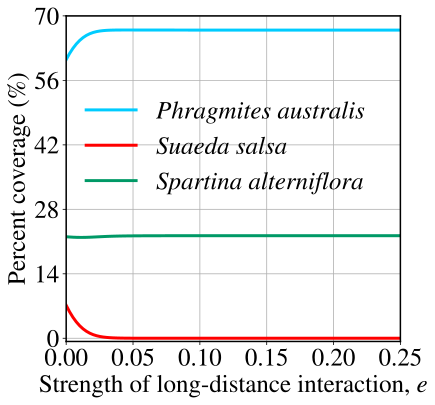

In [16]:
nticker = 6
from matplotlib import ticker
fig1, ax = plt.subplots(1, 1, figsize=(6, 6))
# line10, = ax.plot(EE , PhMean[0,:]*100, lw=2, color='b', label='P. australis'); 
# line11, = ax.plot(EE , SuMean[0,:]*100, lw=2, color='r', label='S. salsa'); 
# line12, = ax.plot(EE , SpMean[0,:]*100, lw=2, color='g', label='S. alterniflora'); 
line10, = ax.plot(EE , PhMean[0,:]*100, lw=3, color='#00CCFF', label='$Phragmites$ $australis$'); 
line11, = ax.plot(EE , SuMean[0,:]*100, lw=3, color='r', label='$Suaeda$ $salsa$'); 
line12, = ax.plot(EE , SpMean[0,:]*100, lw=3, color='#009966', label='$Spartina$ $alterniflora$'); 

ax.set_xlim(0.0, 0.25)
ax.set_xticks(np.linspace(0.0,0.25,nticker))

ax.set_ylim(-0.7, 70)
# Ylabels = np.linspace(0.0, 0.7,nticker).round(1)
ax.set_yticks(np.linspace(0.0, 70,nticker))

ax.set_xlabel('Strength of long-distance interaction, $e$');
ax.set_ylabel('Percent coverage (%)');

ax.spines['bottom'].set_linewidth(1.5);
ax.spines['left'].set_linewidth(1.5);
ax.spines['right'].set_linewidth(1.5);
ax.spines['top'].set_linewidth(1.5);

ax.legend(fontsize=FS,frameon=False,loc=(0.03,0.42))
ax.grid()
fig1.savefig('Figure 4d Trajectories & Equilibrium.pdf',bbox_inches='tight')

© 2021, Kang Zhang, ECNU. Follow Johan van de Koppel & Quan-Xing Liu.